# Salary Predictions Based on Job Descriptions

# Problem Description

The task is to examine a set of job postings with salaries and then predict salaries for a new set of job postings. This a regression problem

# Basic Data Analysis Library

In [1]:
# Basic data analysis libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Personal Information
__author__ = "Emrul Hasan"
__email__ = "emrul.phy@gmail.com"

## Functions to load and clean the data

In [2]:
# Load data
def load_data(df):
    return pd.read_csv(df)

#Merging data
def full_data(df1,df2,key=None ):
    return pd.merge(df1, df2,on=key)

# remove lower outliers and drop the job id
def clean_outliers(df):
    df=df[df.salary>8.5]
    return df

# drop the jobId column
def drop_col(df,col):
    return df.drop(columns=[col])

# Encode categorical data: label encoding for ordinal data and One hot encoding for nominal data
from sklearn.preprocessing import LabelEncoder

def encode_cat(df,x1,x2):
    for col in x1:
        df[col]=LabelEncoder().fit_transform(df[col])
    
    clean_data=pd.get_dummies(df, columns=x2)
    
    return clean_data.drop(columns=['jobId'])

# Defining data and variables

In [3]:
# load data
train_data=load_data('train_features.csv')
test_data=load_data('test_features.csv')
salary_data=load_data('train_salaries.csv')

# Merging data
train=full_data(train_data, salary_data,key='jobId')

# Define nominal and ordinal categorical Variables
var1=['jobType','degree'] # ordinal data
var2=['major','industry'] # Nominal data

# Numerical Columns
num_col=['yearsExperience', 'milesFromMetropolis']

# Remove the outliers and drop the jobId column
train_df=clean_outliers(train)

#test=clean_outliers(test_data)

# encode the data
clean_data=encode_cat(train_df,var1,var2)
test_clean=encode_cat(test_data,var1,var2)

feature_df=drop_col(clean_data,'companyId')
feature_df=drop_col(feature_df,'salary')
test_df=drop_col(test_clean,'companyId')

target_df=clean_data['salary']


C:\Users\T420\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Baseline Model

In [4]:
# Import MLlibraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.utils import shuffle

In [5]:
def Baseline_model(df,col,target):
    avg_target=df.groupby([col])[target].mean().reset_index()
    target_df=df[target]
    df.drop(target,axis=1, inplace=True)
    X_train, X_test, Y_train, Y_test = train_test_split(df, target_df, test_size=0.3,random_state=42)
    Baseline_data=X_test.merge(avg_target,on=[col])
    Baseline_predictions=Baseline_data[target]
    Baseline_MSE=mean_squared_error(Y_test, Baseline_predictions)
    
    print('Baseline Model MSE: {}'.format(Baseline_MSE))
   

In [6]:
Baseline_model(train,'industry','salary')

Baseline Model MSE: 1634.6951926513882


# Model Building

In [7]:
# Four importnat Models
ML_model=[
    LinearRegression(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor()
]

def model_fit(models,feature,target):
    
    MSE=[]
    CV_STD=[]
    model_name=[]
    for model in models:

        neg_mse = cross_val_score(model, feature, target, cv=2, scoring='neg_mean_squared_error',n_jobs=2)
        mean_mse= -1.0*np.mean(neg_mse)
        MSE.append(mean_mse)
        cv_std= np.std(neg_mse) 
        CV_STD.append(cv_std)
        model_name.append(model.__class__.__name__)
    
    result=pd.DataFrame({'Model':model_name,'CV_std': CV_STD, 'MSE':MSE})
    
    result=result.sort_values(by='MSE',ascending=True).reset_index()
    print("\nResult:\n", result)
    
    min_MSE=min(result['MSE'])
    best_model=result['Model'][0]# first row and first column
    
    print('The minimum MSE is {} and the best model is {}'.format(min_MSE,best_model))

model_fit(ML_model,feature_df,target_df)



Result:
    index                      Model    CV_std         MSE
0      2  GradientBoostingRegressor  1.850369  377.454028
1      3               XGBRegressor  2.064060  377.567446
2      1      RandomForestRegressor  0.827448  465.440611
3      0           LinearRegression  1.491366  719.378098
The minimum MSE is 377.45402752571226 and the best model is GradientBoostingRegressor


# Parameter tunning

In [12]:
from sklearn.model_selection import GridSearchCV

In [18]:
# Search for best parameters
parameter = {'n_estimators':[100,150,200,250],
            'max_depth':[4,5,6,7],
            'learning_rate':[0.1,0.2,0.3,0.4]
            }

def param_search(param_grid, n_jobs):
    estimator = GradientBoostingRegressor() 
    #cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2)
    GridCV= GridSearchCV(estimator=estimator, cv=2, param_grid=param_grid, n_jobs=n_jobs) 
    GridCV.fit(feature_df, target_df) 

    return GridCV.best_params_ 

param_search(parameter,2)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}

In [19]:
# Result for best parameters
GBReg=GradientBoostingRegressor(n_estimators=250,learning_rate=0.1, max_depth=5)
kfold=2
def best_score(model,feature, target,cv=kfold):
    neg_mse = cross_val_score(model, feature, target, cv=kfold, scoring='neg_mean_squared_error', n_jobs=2)
    mean_mse= -1.0*np.mean(neg_mse)
    cv_std= np.std(neg_mse)
    
    print('Tunned MSE for best model is {} '.format(mean_mse))

best_score(GBReg,feature_df, target_df,cv=kfold)   

Tunned MSE for best model is 356.41210502710135 


# Predictions

In [22]:
#Predictions with the best model
print('\nPredictions with best model:')

model=GradientBoostingRegressor(n_estimators=250,learning_rate=0.1, max_depth=5)

predictions=model.fit(feature_df, target_df)

#create predictions based on test data
predictions = model.predict(test_df)
predictions


Predictions with best model:


array([111.42516715,  92.45180307, 178.23470845, ...,  56.41271313,
       166.10157223, 112.05788983])

# Feature Importance

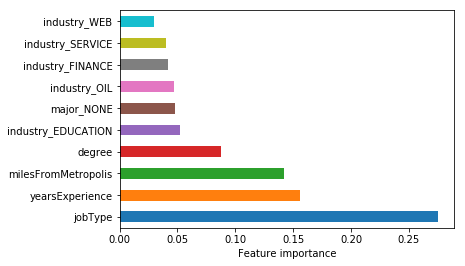

In [21]:
# Function to calculate important features
def plot_feature(model, df):
    feat_importances = pd.Series(model.feature_importances_, index=df.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.xlabel('Feature importance')
    plt.show()

plot_feature(model,feature_df)

Most important feature is jobType followed by yearsExperience, milesFromMetropolis and degree